In [6]:
%reload_kedro
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

2021-05-31 15:51:01,715 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-05-31 15:51:01,763 - root - INFO - ** Kedro project Foehn fire impact
2021-05-31 15:51:01,764 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-05-31 15:51:01,772 - root - INFO - Registered line magic `run_viz`


In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from modelling_utils import *
import kedro.framework.context
import os
import json

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

# Load data

In [9]:
# Predefined regions and stations therein
# Eliminated stations: "DAV", "ABO", "GIH", "ENG", "ELM", "GLA", "EBK", "SMA", "WAE", "STG", "ARH", "GUT", "OBR", "HOE" 
regions = context.config_loader.get("regions.json")

In [10]:
# Load station CSV, adjust some values in full station name to map to fire indice data
df_stations = context.catalog.load("foehn_stations")

# Define mapping
station_mapping = {"Bad Ragaz": "Bad_Ragaz", 
                   "Güttingen": "Guttingen",
                   "Hörnli": "Hornli",
                   "Locarno / Monti": "Locarno_Monti",
                   "S. Bernardino": "S_Bernardino",
                   "St. Gallen": "St_Gallen", 
                   "Wädenswil": "Wadenswil",
                   "Zürich / Fluntern": "Zurich_Fluntern"}

# Create mapping from abbreviation to fullname (map above values, leave others as they are)
abbrev_dict = dict(zip(df_stations["abbreviation"], df_stations["name"].map(station_mapping).fillna(df_stations["name"])))

2021-05-31 15:51:04,893 - kedro.io.data_catalog - INFO - Loading data from `foehn_stations` (CSVDataSet)...


In [11]:
# Read all data from relevant stations into a dataframe
df_raw = pd.DataFrame()
for region, stations in regions.items():
    for station in stations:
        
        # Read the 19XX-2012 files
        try:
            filename = os.path.join(context.project_path, "data", "01_raw", "fireindice_1981_2012", f"{abbrev_dict[station]}_RESULT.csv")
            df_temp = pd.read_csv(filename)
            df_temp["station"] = station
            df_temp["region"] = region
            df_raw = pd.concat([df_raw, df_temp], axis=0)
            print(f"(1980-2012) Joined {station}")
        except FileNotFoundError:
            print(f"(1980-2012) {station} does not exist")
            
        # Read the 2000-2018 files
        try:
            filename = os.path.join(context.project_path, "data", "01_raw", "fireindice_2000_2018", f"{station}_RESULT.csv")
            df_temp = pd.read_csv(filename)
            df_temp["station"] = station
            df_temp["region"] = region
            df_raw = pd.concat([df_raw, df_temp], axis=0)
            print(f"(2000-2018) Joined {station} ")
        except FileNotFoundError:
            print(f"(2000-2018) {station} does not exist")

(1980-2012) Joined SBO
(2000-2018) SBO does not exist
(1980-2012) Joined LUG
(2000-2018) Joined LUG 
(1980-2012) MAG does not exist
(2000-2018) MAG does not exist
(1980-2012) Joined OTL
(2000-2018) Joined OTL 
(1980-2012) Joined GRO
(2000-2018) GRO does not exist
(1980-2012) Joined CEV
(2000-2018) CEV does not exist
(1980-2012) COM does not exist
(2000-2018) Joined COM 
(1980-2012) Joined PIO
(2000-2018) Joined PIO 
(1980-2012) Joined VIO
(2000-2018) VIO does not exist
(1980-2012) ROB does not exist
(2000-2018) Joined ROB 
(1980-2012) Joined SBE
(2000-2018) SBE does not exist
(1980-2012) Joined VIS
(2000-2018) Joined VIS 
(1980-2012) Joined MVE
(2000-2018) Joined MVE 
(1980-2012) Joined SIO
(2000-2018) Joined SIO 
(1980-2012) Joined EVI
(2000-2018) EVI does not exist
(1980-2012) Joined AIG
(2000-2018) AIG does not exist
(1980-2012) Joined AND
(2000-2018) AND does not exist
(1980-2012) Joined CHU
(2000-2018) CHU does not exist
(1980-2012) Joined RAG
(2000-2018) Joined RAG 
(1980-2012) J

In [12]:
# Convert date string to data
df_raw["DateYYYYMMDD"] = pd.to_datetime(df_raw["DateYYYYMMDD"], format='%Y%m%d')

In [13]:
# Ensure a consistent time axis from beginning 1981 until end 2018
time_axis = pd.DataFrame({"DateYYYYMMDD": pd.date_range(start="1981-01-01", end="2018-12-31", freq="1D")})

In [14]:
# Join fire indice data onto time axis and remove duplicates due to overlapping datasets (keep value from first dataset)
df_full = pd.merge(time_axis, df_raw, on="DateYYYYMMDD", how="left")
df_full = df_full.loc[~df_full.duplicated(subset=["DateYYYYMMDD", "station"], keep ="first"), :]
df_full = df_full.rename(columns={"DateYYYYMMDD": "date"})

In [15]:
pd.set_option('display.max_columns', 500)
df_full

,date,Date,year,month,day,gh,gcs,eta.etp.S,eta.etp.C,T,Tmax,Tmin,Tdew,Tdew12,Tdew15,H,U,P,PDur,SnowCover,RobiniaBlossom,BirchLeaves,PC,N,DaysSinceRain,AgeRainEvent_2_20,WeekRain,RainSum,lastRainSum,lastRainSum_2_20,VPD,VPD12,VPD13,Angstroem,Nesterov,Munger,EMC,FFWI,FFWImod,KBDI,KBDISI,Sharples,FMI,Baumgartner,BaumgartnerDanger,NetRad,PETpen,PETthorn,PETthorn_camargo,PETthorn_pereira,r,OrieuxDanger,rs,I87,M68,pM68,M68dwd,pM68dwd,FFDI,DFnoble,DFgriffith,DFgriffithAdj,FWI,ISI,BUI,FFMC,DMC,DC,Ifa,station,region,SnowCoverOrig,Ra,Rs_fromT,res,res_surf,FWI_lat,BUI_lat,DMC_lat,DC_lat,Risico_dffm,IREPI
0,1981-01-01,1981-01-01,1981.0,1.0,1.0,48.6,91.5,1.000,0.272,6.1,14.9,-1.6,-3.237205,-3.237205,-3.237205,51.1,4.1,0.0,0.000000,0.0,0,0,100,8.547945,17.0,17.0,0.0,0.0,5.1,5.1,0.547100,0.460444,0.460444,4.645,259.525430,144.5,10.131817,14.640018,10.542891,8.423133,2.141161,0.192941,21.250,4.143062,NaN,-1.511039,1.928723,0.538105,1.825045,0.597612,146.773273,0.0,7.174174,0.923140,0.0,0.0,0.0,0.0,2.125241,5.672841,5.776432,5.724794,2.094262,3.866260,2.989115,83.989807,3.274189,4.340000,NaN,SBO,southern_switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-01,1981-01-01,1981.0,1.0,1.0,52.2,85.8,0.900,0.272,7.0,16.0,0.3,-3.244628,-3.244628,-3.244628,48.0,4.3,0.0,0.000000,0.0,0,0,100,8.527043,17.0,17.0,0.0,0.0,3.3,3.3,0.635063,0.520966,0.520966,4.400,581.716978,144.5,9.253438,16.465953,11.868585,19.943597,5.069702,0.212346,20.250,5.932431,NaN,-1.524196,2.307561,0.551249,1.802126,0.673825,143.724660,0.0,5.673762,1.317014,0.0,0.0,0.0,0.0,2.564911,5.868063,6.120894,5.924360,4.286712,4.724932,7.182137,85.198994,7.310004,14.152067,NaN,LUG,southern_switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-01,1981-01-01,1981.0,1.0,1.0,58.6,89.5,0.688,0.272,7.1,16.5,1.2,-4.250869,-4.250869,-4.250869,44.2,1.7,0.0,0.000000,0.0,0,0,100,8.505007,17.0,17.0,0.0,0.0,3.1,3.1,0.709615,0.562887,0.562887,4.200,422.143723,144.5,8.642371,7.025508,5.066205,23.619704,6.003997,0.186770,19.275,4.695115,NaN,-1.527740,1.360858,0.591660,1.860118,0.784224,146.010879,0.0,6.616924,0.481036,0.0,0.0,0.0,0.0,2.377103,5.922698,6.223141,5.975616,2.211034,3.006732,6.056194,85.341013,6.284055,9.811209,NaN,OTL,southern_switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-01,1981-01-01,1981.0,1.0,1.0,25.5,47.9,1.000,0.272,5.3,14.5,-3.1,-3.118269,-3.118269,-3.118269,54.5,3.1,0.0,0.000000,0.0,0,0,100,8.494156,17.0,17.0,0.0,0.0,3.5,3.5,0.486214,0.405290,0.405290,4.895,162.851153,144.5,10.463320,10.822092,7.794383,10.697839,2.719503,0.161435,22.300,3.529202,NaN,-1.748719,1.349626,0.439790,1.815023,0.480973,147.700927,0.0,7.901699,0.592316,0.0,0.0,0.0,0.0,1.703858,5.737387,5.855447,5.768985,0.962858,2.903374,2.506133,83.189627,2.825323,3.424938,NaN,GRO,southern_switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-01,1981-01-01,1981.0,1.0,1.0,37.5,61.7,1.000,0.272,4.5,14.4,-3.1,-3.621703,-3.621703,-3.621703,55.5,2.6,0.0,0.000000,0.0,0,0,100,8.485505,17.0,20.0,0.0,0.0,1.5,0.0,0.473160,0.374837,0.374837,5.025,-10.382328,144.5,10.605704,9.009918,6.488730,9.389211,2.386630,0.158242,22.750,2.408005,NaN,-1.735228,1.173714,0.383631,1.830133,0.503327,148.227451,0.0,8.343058,0.461202,0.0,0.0,0.0,0.0,1.529474,5.761966,5.827429,5.743842,0.647962,2.342233,1.284245,82.204603,1.369733,2.826000,NaN,CEV,southern_switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347351,2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,3.8,0.9,1.354334,1.354334,1.354334,91.5,1.2,4.8,4.179528,NaN,0,0,100,8.377548,0.0,0.0,10.2,10.2,10.2,9.2,0.061789,0.062604,0.062604,7.015,0.000000,0.0,22.264786,1.311955,0.944607,0.000000,0.000000,0.134057,32.225,-3.41

In [16]:
indice_cols_to_keep = ["date", "station", "region", "T", "Tmax", "Tmin", "H", "U", "P", "DaysSinceRain", "VPD", "Angstroem", "Nesterov", "FFWI", "Baumgartner", "OrieuxDanger", "FWI"]

# Load and preprocess fire data

In [17]:
df_fires = context.catalog.load("fire_data_with_foehn_and_control_variables")
df_fires["date"] = df_fires["start_date_min"].dt.date.astype(np.datetime64)
df_fires = df_fires.rename(columns={"closest_station": "station"})

2021-05-31 15:51:52,423 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [18]:
fire_cols_to_keep = ["date", "station", "altitude [m asl]", "exposition", "slope [%]", "total [ha]", "duration_min", "duration_max", "closest_station_distance", "foehn_minutes_24_hour_before", "foehn_minutes_48_hour_before", "foehn_minutes_during_6_hours_after_start_of_fire", "FF_mean_during_6_hours_after_start_of_fire", "FFX_mean_during_6_hours_after_start_of_fire", "FF_mean_during_12_hours_after_start_of_fire", "FFX_mean_during_12_hours_after_start_of_fire", "fire_regime", "potential_foehn_species", "decade"]

In [19]:
df_BA = pd.merge(df_fires[fire_cols_to_keep], df_full[indice_cols_to_keep], on = ["date", "station"], how="left")

# Burned area prediction model

In [20]:
final_features = ["T", "Tmax", "Tmin", "H", "U", "P", "DaysSinceRain", 
                  "VPD", "Angstroem", "Nesterov", "FFWI", "Baumgartner", "OrieuxDanger", "FWI", 
                  "altitude [m asl]", "slope [%]", "total [ha]", "duration_min", "duration_max", "closest_station_distance", 
                  "foehn_minutes_24_hour_before", "foehn_minutes_48_hour_before", "foehn_minutes_during_6_hours_after_start_of_fire", 
                  "FF_mean_during_6_hours_after_start_of_fire", "FFX_mean_during_6_hours_after_start_of_fire", "FF_mean_during_12_hours_after_start_of_fire", 
                  "FFX_mean_during_12_hours_after_start_of_fire"]

df_BA = df_BA.loc[df_BA["region"] == "southern_switzerland", final_features]
df_BA = df_BA.rename(columns={"total [ha]": "burned_area", "slope [%]": "slope", "altitude [m asl]": "altitude"})
#df_BA = df_BA.loc[df_BA["burned_area"].notnull(), :]
df_BA["burned_area"] = np.log10(df_BA["burned_area"])
#df_BA = df_BA.loc[df_BA["burned_area"]<10, :]
final_features.remove("total [ha]")

<AxesSubplot:>

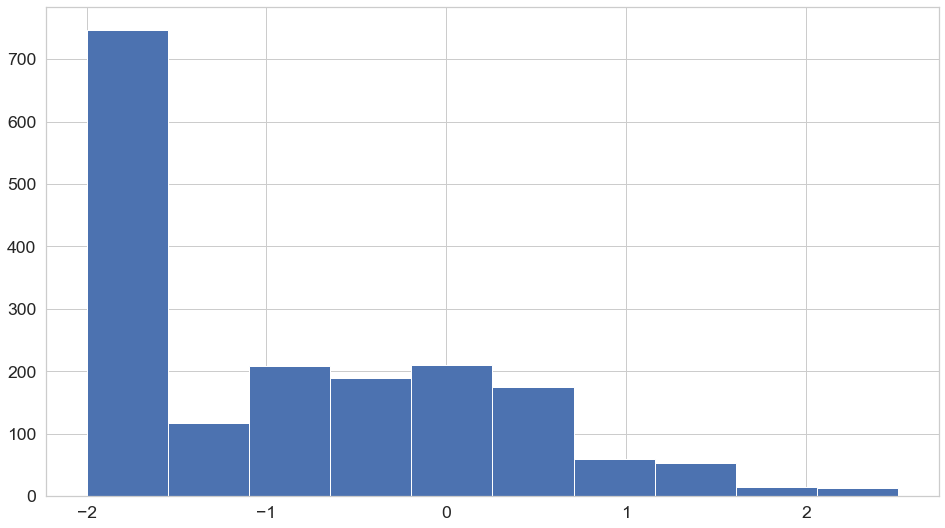

In [21]:
df_BA["burned_area"].hist()

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


In [23]:
clf = XGBRegressor(n_jobs=30, max_depth=1, n_estimators=200, use_label_encoder=False)
X_train, X_test, y_train, y_test = train_test_split(df_BA.drop(columns=["burned_area"]), df_BA["burned_area"], shuffle=True, test_size=0.2)

In [24]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=30, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

-- Train set performance -- 
(MAE) Mean absolute error:  0.5334
(MSE) Mean squared error:  0.457
(RMSE) Root mean squared error:  0.676
(R2) R2-score:  0.6226
-- Test set performance -- 
(MAE) Mean absolute error:  0.6568
(MSE) Mean squared error:  0.6605
(RMSE) Root mean squared error:  0.8127
(R2) R2-score:  0.4613


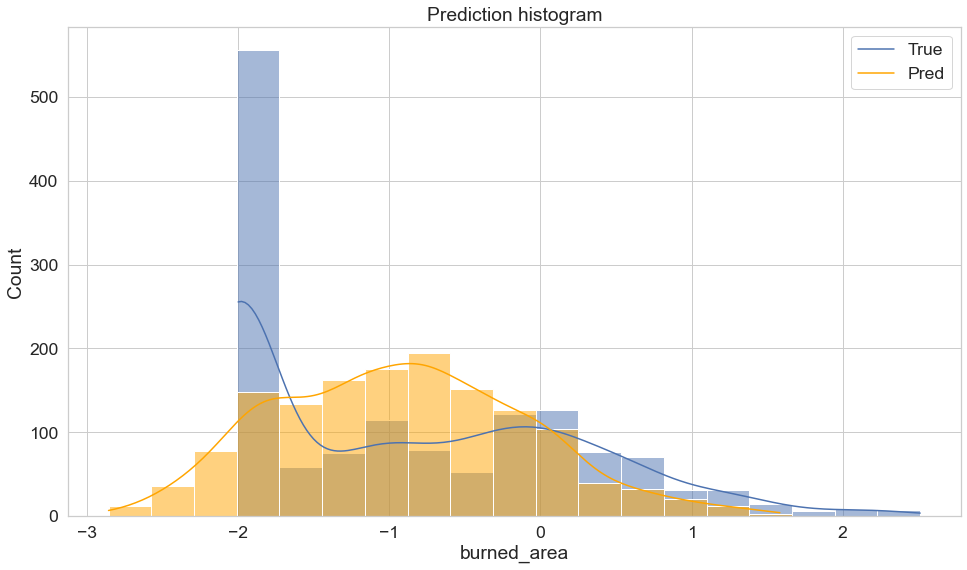

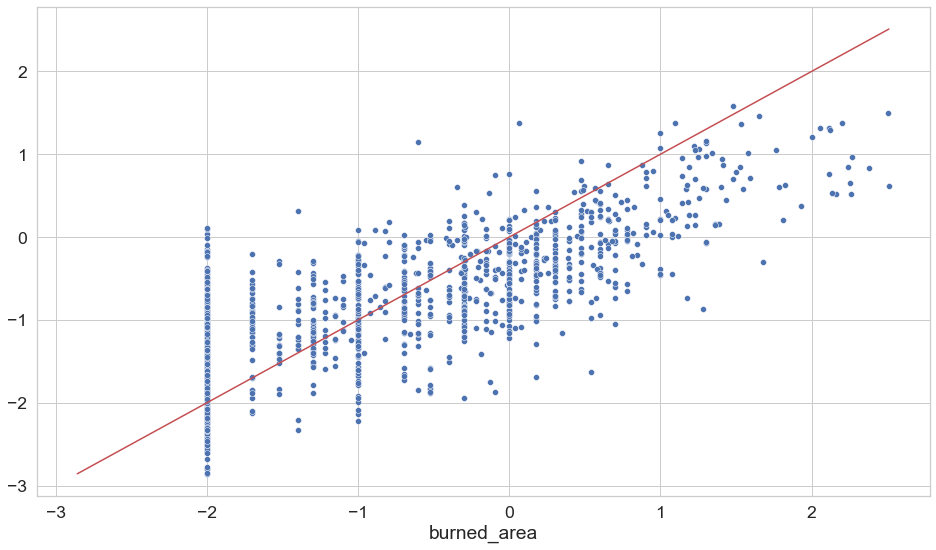

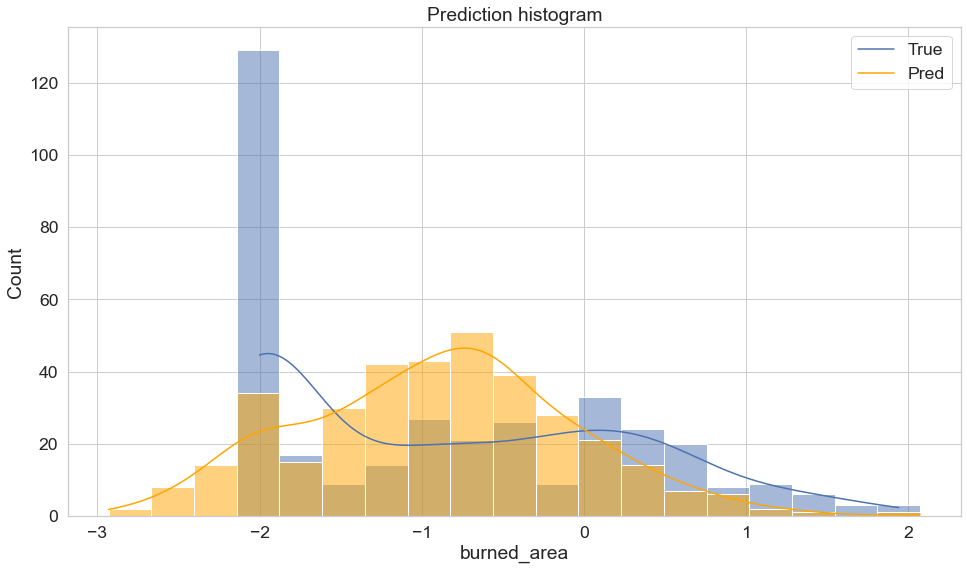

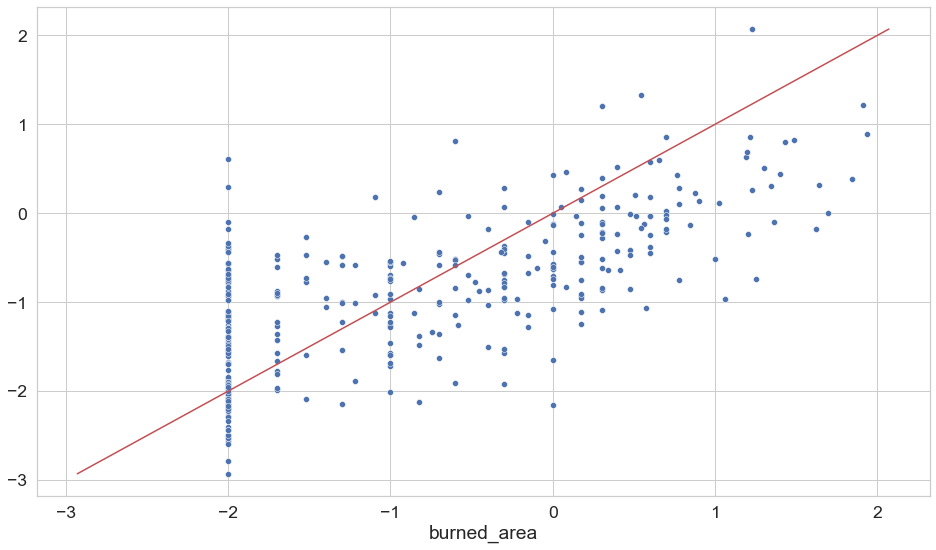

In [25]:
import warnings
warnings.filterwarnings("ignore")
print("-- Train set performance -- ")
evaluate_regression(y_train, clf.predict(X_train))
print("-- Test set performance -- ")
evaluate_regression(y_test, clf.predict(X_test))

<AxesSubplot:xlabel='importance', ylabel='feature'>

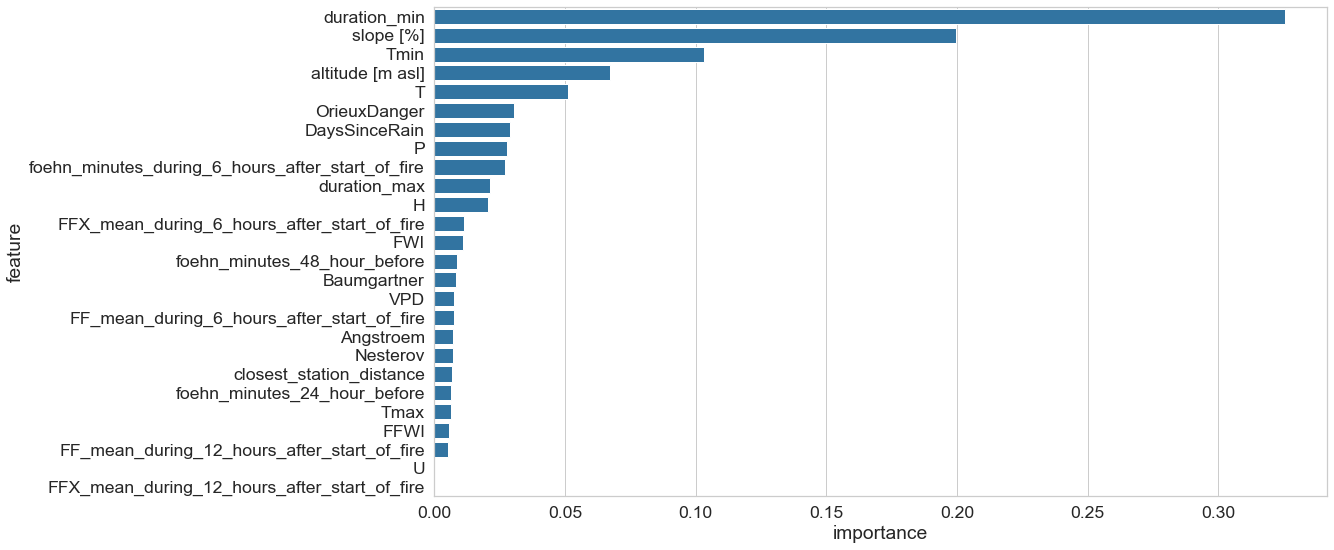

In [26]:
imp = pd.DataFrame({"feature": final_features, "importance": clf.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(y=imp["feature"], x=imp["importance"], color="tab:blue")

## Fire pred model

In [157]:
df_OC = pd.merge(df_full[indice_cols_to_keep], df_fires[["date", "station","total [ha]"]], on = ["date", "station"], how="left")
df_OC = df_OC.loc[~df_OC.duplicated(subset=["date", "station"]),:]
df_OC["fire"] =np.NaN
df_OC.loc[df_OC["total [ha]"].notnull(), "fire"] =1
df_OC.loc[df_OC["total [ha]"].isnull(), "fire"] =0 

df_OC = df_OC.rename(columns={"total [ha]": "burned_area"})

df_OC["month"]  =df_OC["date"].dt.month

In [165]:
df_foehn = context.catalog.load("foehn_data_prepared")
df_foehn["date"] = df_foehn["date"].dt.date.astype(np.datetime64)

2021-05-31 17:41:08,416 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [171]:
df_agg["date"].dtype #== df_OC["date"].dtype

dtype('O')

In [174]:
# df_foehn["year"]  =df_foehn["date"].dt.year
# df_foehn["month"]  =df_foehn["date"].dt.month
# df_foehn["day"]  =df_foehn["date"].dt.day

df_agg = df_foehn.filter(regex="(_foehn|date)").groupby(by=df_foehn["date"].dt.date).sum().reset_index().melt(id_vars="date", var_name="station", value_name="foehn_minutes")
df_agg["station"]  = df_agg["station"].str.split("_").str[0]
df_agg["date"] = df_agg["date"].astype(np.datetime64)

In [175]:
df_OC = pd.merge(df_OC, df_agg[["date","station","foehn_minutes"]], on = ["date", "station"], how="left")

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [177]:
clf = XGBClassifier(scale_pos_weight=(df_OC["fire"] == 0).sum()/(df_OC["fire"] == 1).sum(), n_jobs=10, max_depth=4, n_estimators=100, use_label_encoder=False)
X_train, X_test = train_test_split(df_OC.loc[df_OC["region"]=="southern_switzerland", :], )

In [178]:
X_train.columns

Index(['date', 'station', 'region', 'T', 'Tmax', 'Tmin', 'H', 'U', 'P',
       'DaysSinceRain', 'VPD', 'Angstroem', 'Nesterov', 'FFWI', 'Baumgartner',
       'OrieuxDanger', 'FWI', 'burned_area', 'fire', 'month', 'foehn_minutes'],
      dtype='object')

In [179]:
clf.fit(X_train.drop(columns=["date", "station", "region", "burned_area", "fire"]), X_train["fire"])

[17:44:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=148.1243052046488,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [180]:
pred = clf.predict_proba(X_test.drop(columns=["date", "station", "region", "burned_area", "fire"]))

AUROC:  0.810926211097133
Log. loss:  0.4372624424656826
Best threshold with F1-score:  0.9196968
Precision:  0.1085972850678733
Recall:  0.1769041769041769
F1:  0.13457943925233645


0.9196968

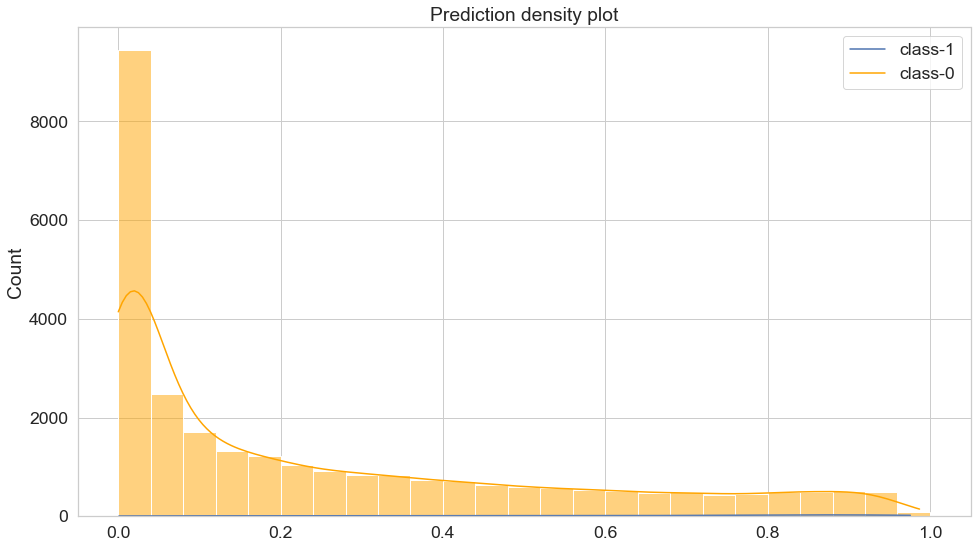

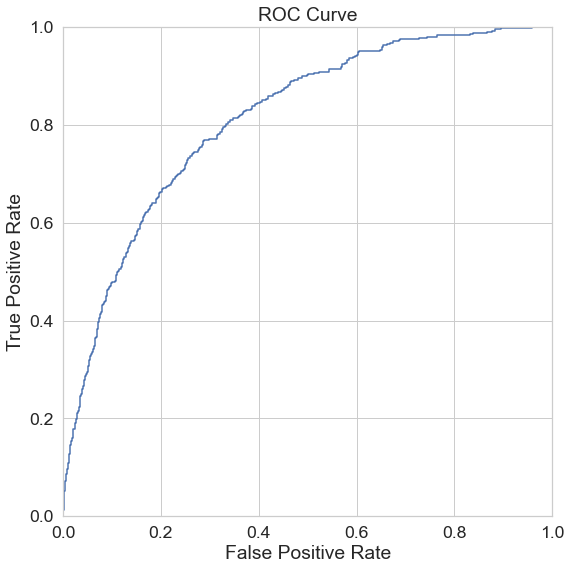

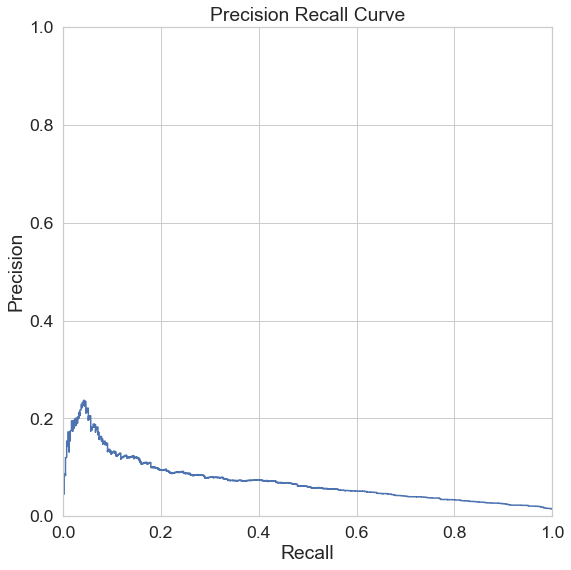

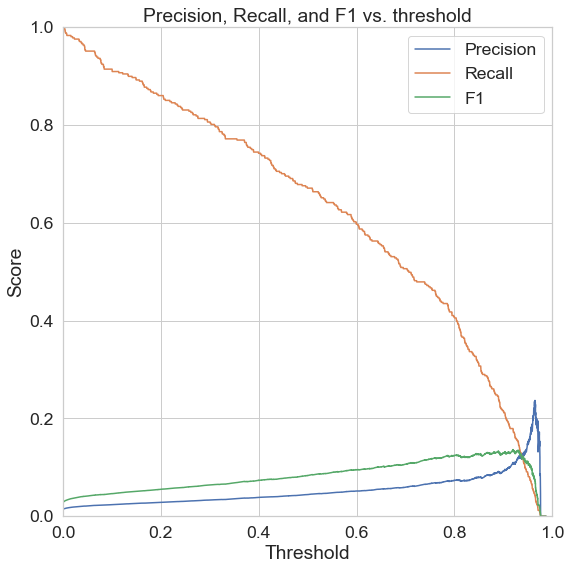

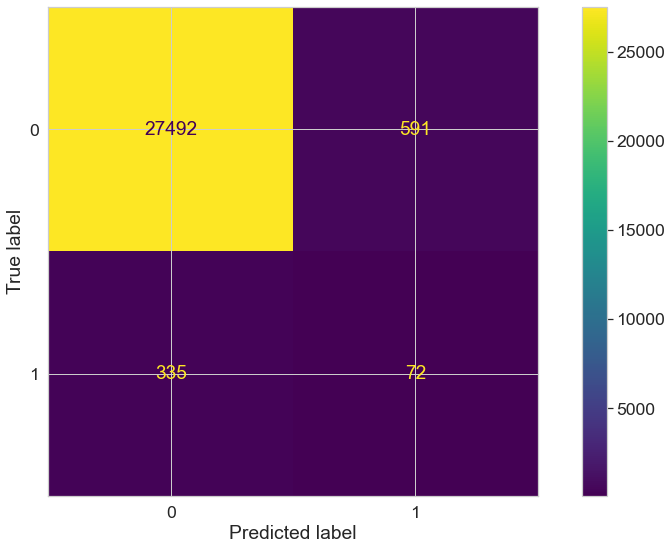

In [181]:
evaluate_binary_classification(y_true=X_test["fire"], y_proba=pred[:,1])

<AxesSubplot:xlabel='importance', ylabel='feature'>

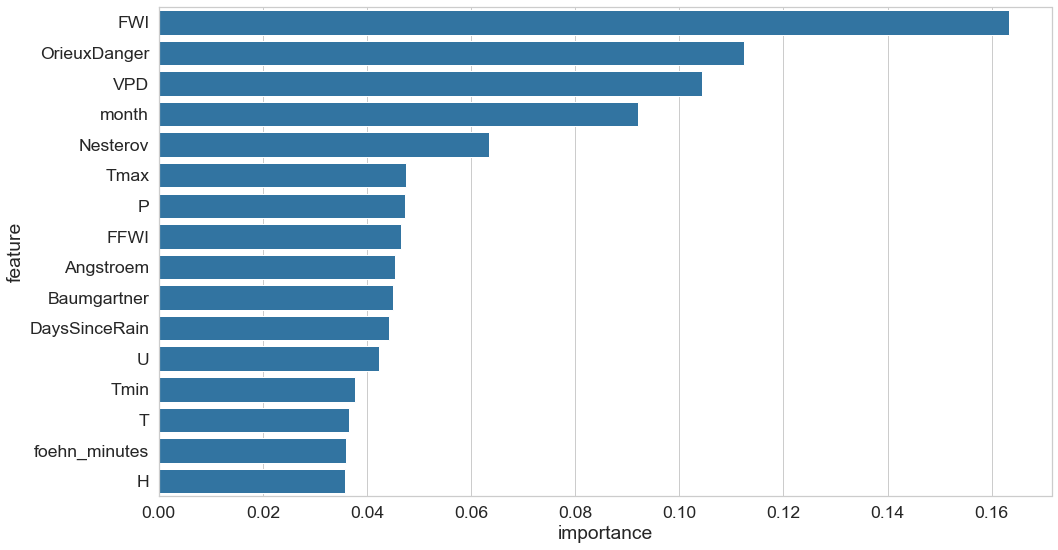

In [182]:
imp = pd.DataFrame({"feature": X_train.drop(columns=["date", "station", "region", "burned_area", "fire"]).columns, "importance": clf.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(y=imp["feature"], x=imp["importance"], color="tab:blue")